In [3]:
import pandas as pd

In [13]:
train = pd.read_csv('memberlevel.csv')
test = pd.read_csv('memberlevel_test.csv')

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Separate features and target
X = train.drop(['MemberID', 'next_buy'], axis=1)
y = train['next_buy']

numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = [col for col in X.columns if col not in numeric_cols]

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [15]:
train['next_buy'].value_counts(normalize=True)

next_buy
0    0.93908
1    0.06092
Name: proportion, dtype: float64

In [16]:
X_preprocessed = preprocessor.fit_transform(X)

feature_names = preprocessor.get_feature_names_out()
X_preprocessed = pd.DataFrame(X_preprocessed, columns=feature_names, index=X.index)

In [17]:
X_test = test.drop(['MemberID'], axis=1)

X_test_preprocessed = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=feature_names, index=X_test.index)

### find closest distance

In [18]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Fit kNN using test rows as reference
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(X_test_preprocessed)

NearestNeighbors(metric='euclidean', n_neighbors=1)

In [19]:
# Split the train set into positive and negative classes
positive_train = train[train['next_buy'] == 1]
negative_train = train[train['next_buy'] == 0]

# For both classes, find distance to test set
pos_distances, _ = nn.kneighbors(X_preprocessed.loc[positive_train.index])
neg_distances, _ = nn.kneighbors(X_preprocessed.loc[negative_train.index])

# Add distances back
positive_train = positive_train.copy()
negative_train = negative_train.copy()
positive_train['distance'] = pos_distances
negative_train['distance'] = neg_distances

# Select top N% most similar rows from each class
keep_pos = positive_train.sort_values('distance').head(int(len(positive_train) * 0.8))
keep_neg = negative_train.sort_values('distance').head(int(len(negative_train) * 0.2))

# Combine to form your filtered training set
filtered_train = pd.concat([keep_pos, keep_neg])

In [20]:
filtered_train['next_buy'].value_counts(normalize=True)

next_buy
0    0.794
1    0.206
Name: proportion, dtype: float64

## Model

In [45]:
# Separate features and target
X = filtered_train.drop(['MemberID', 'next_buy', 'distance'], axis=1)
y = filtered_train['next_buy']

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

### KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(
    n_neighbors=3,        # try odd values, 3 - 25
    weights='distance',         # gives closer neighbors more influence
    metric='euclidean',         # or try 'manhattan'
    n_jobs=-1
)

In [ ]:
knn_model = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', model)
])

knn_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['num_transactions',
                                                   'total_qty', 'avg_qty',
                                                   'total_spent', 'avg_spent',
                                                   'unique_products',
                                                   'unique_categories',
                                                   'unique_sources',
                                                   'NoOfChild',
                                                   'days_since_last_purchase',
                                                   'days_since_first_purchase...
                                                   'eldest_kid_age',
                                                   'join_month', 'join_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['most_common_category',
                                                   'most_common_source',
                                                   'City'])])),
                ('knn',
                 KNeighborsClassifier(metric='euclidean', n_jobs=-1,
                                      n_neighbors=3, weights='distance'))])

In [34]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, make_scorer

# Validation performance
val_preds = knn_model.predict(X_val)
val_bal_acc = balanced_accuracy_score(y_val, val_preds)
print('Validation Balanced Accuracy:', val_bal_acc)

# Cross-validation on training set only
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    knn_model, X_train, y_train,
    cv=cv,
    scoring=make_scorer(balanced_accuracy_score),
    n_jobs=-1
)
print('CV balanced accuracy mean (on training set):', cv_scores.mean())
print('CV scores:', cv_scores)

Validation Balanced Accuracy: 0.9044616066557556
CV balanced accuracy mean (on training set): 0.9017372826626211
CV scores: [0.90134839 0.89956999 0.90353951 0.90751525 0.89671328]


In [35]:
X_test = test[['most_common_source', 'City', 'purchase_duration', 'days_since_last_purchase']]

prediction = knn_model.predict(X_test)

submission = pd.DataFrame({
    'MemberID': test['MemberID'],
    'next_buy': prediction
})

submission.to_csv('trial36.csv', index=False)

In [39]:
submission['next_buy'].value_counts()

next_buy
0    3885
1    2496
Name: count, dtype: int64

In [ ]:
from sklearn.inspection import permutation_importance

# Permutation Importance
result = permutation_importance(knn_model, X_val, y_val, scoring='balanced_accuracy', n_repeats=5, random_state=42)

# Display top features
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importance_df.head(10))

                     feature  importance_mean  importance_std
9         most_common_source         0.159340        0.012655
10                      City         0.136925        0.008634
14         purchase_duration         0.022128        0.003633
12  days_since_last_purchase         0.017967        0.001908
0           num_transactions         0.008510        0.002821
8             unique_sources         0.007522        0.001293
1                  total_qty         0.007066        0.003547
3                total_spent         0.006733        0.003603
11                 NoOfChild         0.004958        0.001360
18                join_month         0.004834        0.002621


In [33]:
X_top2 = X[['most_common_source', 'City', 'purchase_duration', 'days_since_last_purchase']]

numeric_cols = X_top2.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = [col for col in X_top2.columns if col not in numeric_cols]

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

X_train, X_val, y_train, y_val = train_test_split(
    X_top2, y, test_size=0.2, stratify=y, random_state=42)

knn_model = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', model)
])

knn_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['purchase_duration',
                                                   'days_since_last_purchase']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['most_common_source',
                                                   'City'])])),
                ('knn',
                 KNeighborsClassifier(metric='euclidean', n_jobs=-1,
                                      n_neighbors=3, weights='distance'))])

In [27]:
val_preds = knn_model.predict(X_val)
val_bal_acc = balanced_accuracy_score(y_val, val_preds)
print('Validation Balanced Accuracy:', val_bal_acc)

# Cross-validation on training set only
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    knn_model, X_train, y_train,
    cv=cv,
    scoring=make_scorer(balanced_accuracy_score),
    n_jobs=-1
)
print('CV balanced accuracy mean (on training set):', cv_scores.mean())
print('CV scores:', cv_scores)

NameError: name 'balanced_accuracy_score' is not defined

### Logistic

In [48]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    class_weight='balanced',     # auto-weights inverse to class freq
    solver='liblinear',          # good for small/medium datasets
    penalty='l2',
    C=1.0                        # can tune this
)

lr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('lr', model)
])

lr_model.fit(X_train, y_train)

# Validation performance
val_preds = lr_model.predict(X_val)
val_bal_acc = balanced_accuracy_score(y_val, val_preds)
print('Validation Balanced Accuracy:', val_bal_acc)

# Cross-validation on training set only
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    lr_model, X_train, y_train,
    cv=cv,
    scoring=make_scorer(balanced_accuracy_score),
    n_jobs=-1
)
print('CV balanced accuracy mean (on training set):', cv_scores.mean())
print('CV scores:', cv_scores)

Validation Balanced Accuracy: 0.9134359656301145
CV balanced accuracy mean (on training set): 0.9333832280619326
CV scores: [0.9421838  0.93743606 0.92591407 0.9358841  0.9254981 ]


In [53]:
prediction = lr_model.predict(X_test)

submission = pd.DataFrame({
    'MemberID': test['MemberID'],
    'next_buy': prediction
})

submission.to_csv('submission39.csv', index=False)

# submission2 = pd.read_csv('trial36.csv')

# # Merge on MemberID
# merged = submission.merge(submission2, on='MemberID', suffixes=('_1', '_2'))

# # Check similarity
# matching = (merged['next_buy_1'] == merged['next_buy_2']).sum()
# total = len(merged)
# similarity = matching / total

# print(f'Matching predictions: {matching} / {total}')
# print(f'Similarity: {similarity:.4%}')

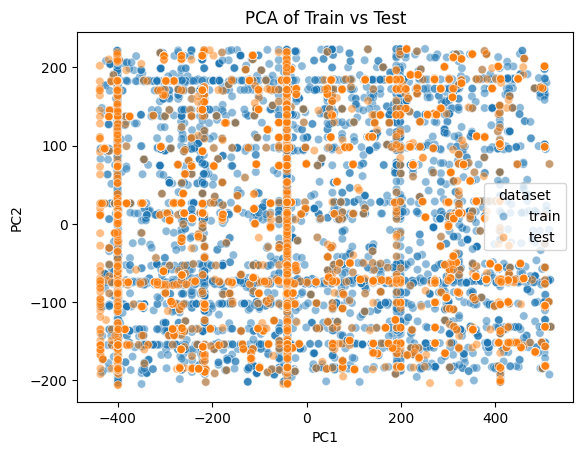

In [54]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Concatenate train and test
X_combined = pd.concat([X_preprocessed, X_test_preprocessed])
X_combined = X_combined.fillna(X_combined.median(numeric_only=True))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_plot['dataset'] = ['train'] * len(X_preprocessed) + ['test'] * len(X_test_preprocessed)

sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='dataset', alpha=0.5)
plt.title('PCA of Train vs Test')
plt.show()

In [57]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

X_all = pd.concat([X_preprocessed, X_test_preprocessed])
y_domain = [0]*len(X_preprocessed) + [1]*len(X_test_preprocessed)

model = XGBClassifier(n_estimators=100)
model.fit(X_all, y_domain)

# AUC near 1 = strong domain shift
print("AUC (train vs test classifier):", roc_auc_score(y_domain, model.predict_proba(X_all)[:,1]))

AUC (train vs test classifier): 0.8521577911874654
